In [2]:
from tqdm import tqdm
import sys
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels import PanelOLS

# features

In [3]:
trains = pd.read_pickle("data/MAD_BAR_trains.pkl")

In [4]:
data = (
    trains.groupby(["train_id", "days_till_dep"])
    .agg(
        mean_econ_price=("Turista_Promo_price", np.nanmean),
        mean_first_price=("Preferente_Promo_price", np.nanmean),
        mean_price=("price", np.nanmean),
        max_econ_seats=("Turista_Promo_seats", max),
        min_econ_seats=("Turista_Promo_seats", min),
        mean_econ_seats=("Turista_Promo_seats", "mean"),
        max_first_seats=("Preferente_Promo_seats", max),
        min_first_seats=("Preferente_Promo_seats", min),
        mean_first_seats=("Preferente_Promo_seats", "mean"),
        departure=("departure", "first"),
        duration=("duration", "first"),
    )
    .dropna(subset=["max_econ_seats", "min_econ_seats"])
    .reset_index()
)

In [5]:
data["econ_seats_sold"] = data["max_econ_seats"] - data["min_econ_seats"]
data["first_seats_sold"] = data["max_first_seats"] - data["min_first_seats"]

In [6]:
data["weekday"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()
)
data["depart_month"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
)
data["depart_hour"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour
)
# only march, april
data = data.loc[data["depart_month"] < 4].reset_index(drop=True)

In [7]:
data["day_part"] = data["depart_hour"] > 12
data["ln_price"] = np.log(data["mean_econ_price"] + 1)
data["ln_econ_seat"] = np.log(data["econ_seats_sold"] + 1)
data["const"] = 1

In [8]:
# filter for those trains, that data is availabel for more than 15 days
id_obs = data.groupby("train_id")["days_till_dep"].count().reset_index()
train_ids = list(id_obs.loc[id_obs["days_till_dep"] > 15]["train_id"].values)

data = data.loc[data["train_id"].isin(train_ids)].reset_index()

In [9]:
#filter for seats sold on an individual day is less than 100
data = data.loc[data["econ_seats_sold"] < 100].reset_index()

In [10]:
# filter for trains, whos data is close to departure day by min(days until departure) < 3)

min_days_until_dep = data.groupby("train_id")["days_till_dep"].min().reset_index()
data = data.loc[
    data["train_id"].isin(
        list(
            min_days_until_dep.loc[min_days_until_dep["days_till_dep"] < 3]["train_id"]
        )
    )
]

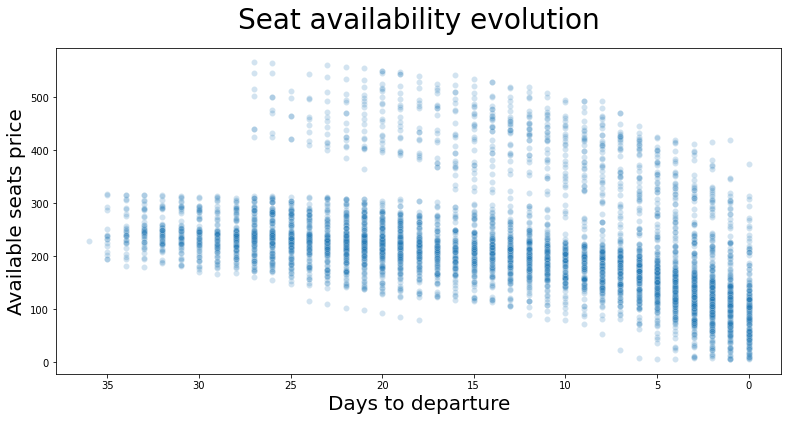

In [11]:
plt.figure(figsize=(13, 6))
sns.scatterplot(data=data, x="days_till_dep", y="mean_econ_seats", alpha=0.2)
plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Available seats price", fontsize=20, fontweight=450)

plt.title("Seat availability evolution", fontsize=28, y=1.04)

plt.savefig("figures/Seat availability evolution", dpi=300)
plt.show()

In [12]:
# differentiate big and small trains, work with small
max_seats = data.groupby("train_id")["mean_econ_seats"].max().reset_index()


data_small =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] < 350]["train_id"])
    )
]

data_big =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] > 350]["train_id"])
    )
]

In [13]:
data = data_small

<AxesSubplot:xlabel='days_till_dep', ylabel='train_id'>

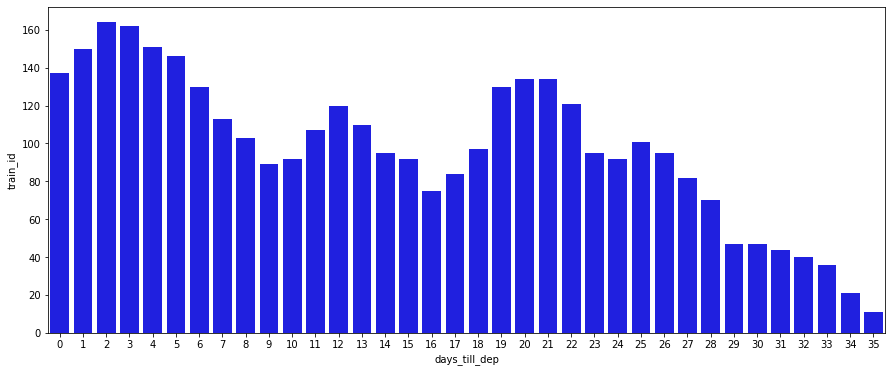

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=data.groupby("days_till_dep")["train_id"].count().reset_index(),
    x="days_till_dep",
    y="train_id",
    color="blue"
)

<AxesSubplot:xlabel='index'>

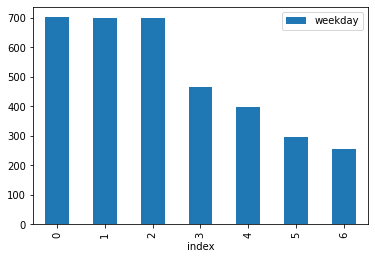

In [15]:
data["weekday"].value_counts().reset_index().sort_values(by="index").set_index(
    "index"
).plot.bar()

<AxesSubplot:>

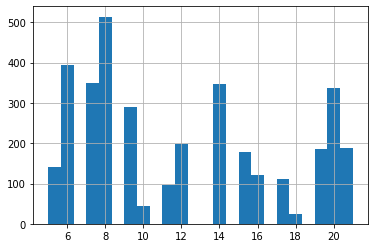

In [16]:
data["depart_hour"].hist(bins=24)

In [17]:
len(data.train_id.unique())

171

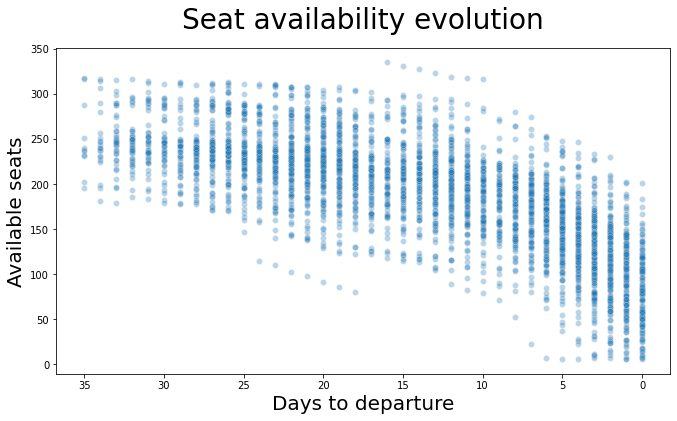

In [18]:
plt.figure(figsize=(11, 6))
sns.scatterplot(data=data, x="days_till_dep", y="mean_econ_seats", alpha=0.3)
plt.gca().invert_xaxis()
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Available seats", fontsize=20, fontweight=450)

plt.title("Seat availability evolution", fontsize=28, y=1.04)

plt.savefig("figures/Seat availability evolution", dpi=300)
plt.show()

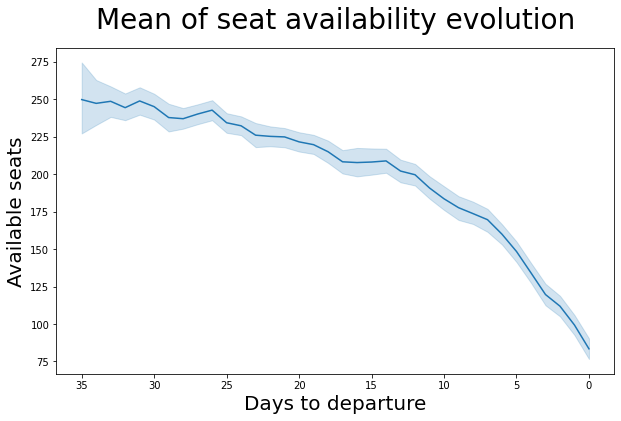

In [34]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="days_till_dep", y="mean_econ_seats", estimator="mean")
plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Available seats", fontsize=20, fontweight=450)

plt.title("Mean of seat availability evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean seat availability evolution", dpi=300)
plt.show()

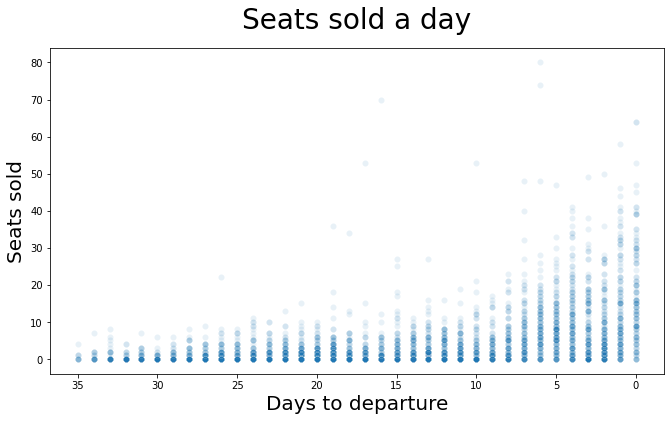

In [20]:
plt.figure(figsize=(11, 6))
sns.scatterplot(data=data_small, x="days_till_dep", y="econ_seats_sold", alpha=0.10)
plt.gca().invert_xaxis()
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Seats sold", fontsize=20, fontweight=450)

plt.title("Seats sold a day", fontsize=28, y=1.04)

plt.savefig("figures/seats_sold_a_day", dpi=300)
plt.show()

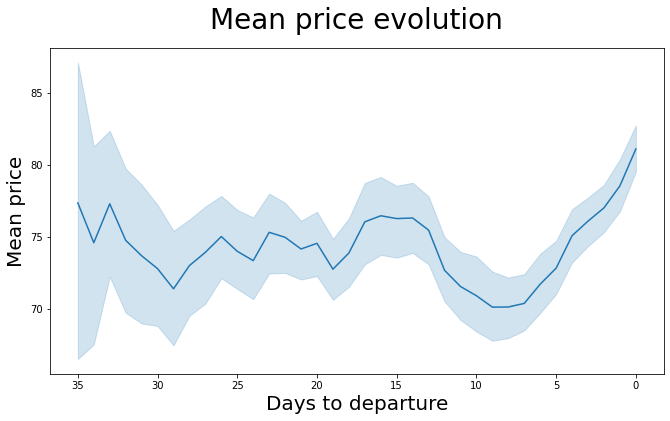

In [21]:
plt.figure(figsize=(11, 6))
sns.lineplot(data=data, x="days_till_dep", y="mean_econ_price", estimator="mean")
plt.gca().invert_xaxis()
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price", fontsize=20, fontweight=450)

plt.title("Mean price evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price evolution", dpi=300)
plt.show()

<AxesSubplot:xlabel='duration', ylabel='ln_price'>

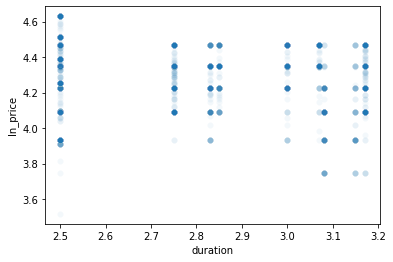

In [27]:
sns.scatterplot(data=data,x="duration",y="ln_price",alpha=0.05)

In [ ]:
sns.scatterplot(data=data,x="duration",y="ln_price",alpha=0.05)

<AxesSubplot:xlabel='weekday', ylabel='ln_price'>

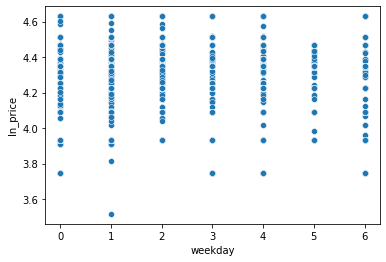

In [28]:
sns.scatterplot(data=data,x="weekday",y="ln_price")

In [43]:
data.to_pickle("data/MAD_BAR_features.pkl")

# models

In [28]:
data = pd.read_pickle("data/MAD_BAR_features.pkl")

In [29]:
data = pd.concat(
    [
        data[["train_id", "departure"]],
        data[data.columns.difference(["train_id", "departure"])].astype("float"),
    ],
    axis=1,
)

In [30]:
data_all = data.set_index(["train_id", "days_till_dep"])

In [31]:
fe_lm = PanelOLS.from_formula(
    "ln_econ_seat ~ ln_price + TimeEffects + EntityEffects",
    data_all,
    drop_absorbed=True,
).fit(cov_type="clustered", cluster_entity=True)

/usr/local/lib/python3.8/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


In [32]:
fe_lm.summary

Dep. Variable:,ln_econ_seat,R-squared:,0.0389
Estimator:,PanelOLS,R-squared (Between):,-44.692
No. Observations:,3517,R-squared (Within):,0.0024
Date:,"Mon, Nov 23 2020",R-squared (Overall):,-24.471
Time:,19:15:03,Log-likelihood,-4261.0
Cov. Estimator:,Clustered,,
,,F-statistic:,133.93
Entities:,171,P-value,0.0000
Avg Obs:,20.567,Distribution:,"F(1,3310)"
Min Obs:,16.000,,
Max Obs:,27.000,F-statistic (robust):,134.07


In [172]:
data_all = data

In [174]:
data_all.loc[data_all["days_till_dep"] == 1].rename(
    columns={"ln_econ_seat": "ln_econ_seat_1"}
)[["train_id", "ln_econ_seat_1"]]

,train_id,ln_econ_seat_1
66,MADRIDBARCELONA2020-02-28 20:00:002020-02-28 2...,2.708050
101,MADRIDBARCELONA2020-02-29 06:20:002020-02-29 0...,2.302585
118,MADRIDBARCELONA2020-02-29 07:30:002020-02-29 1...,1.609438
151,MADRIDBARCELONA2020-02-29 09:30:002020-02-29 1...,0.000000
206,MADRIDBARCELONA2020-02-29 12:30:002020-02-29 1...,3.091042
...,...,...
4159,MADRIDBARCELONA2020-03-12 08:30:002020-03-12 1...,3.218876
4234,MADRIDBARCELONA2020-03-12 12:30:002020-03-12 1...,0.693147
4260,MADRIDBARCELONA2020-03-12 14:00:002020-03-12 1...,1.609438
4281,MADRIDBARCELONA2020-03-12 14:30:002020-03-12 1...,1.791759


In [185]:
data_try = data_all.loc[data_all["days_till_dep"] == i].merge(
    data_all.loc[data_all["days_till_dep"] == i+1].rename(
        columns={"ln_econ_seat": "ln_econ_seat_1"}
    )[["train_id", "ln_econ_seat_1"]],
    on="train_id",
)

In [186]:
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

In [187]:
model = smf.ols(
    formula="ln_price ~ ln_econ_seat + ln_econ_seat_1 + duration + weekday + depart_hour",
    data=data,
)
OLS_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

In [188]:
OLS_reg.summary()

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 23
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     16.85
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           6.64e-29
Time:                        13:21:46   Log-Likelihood:                 128.60
No. Observations:                 133   AIC:                            -207.2
Df Residuals:                     108   BIC:                            -134.9
Df Model:                          24                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.7999      0.144     33.279      0.000       4.517       5.083
weekday[T.1.0]         -0.0330      0.025     -1.309      0.191      -0.082       0.016
weekday[T.2.0]         -0.0222      0.029     -0.774      0.439      -0.078       0.034
weekday[T.3.0]          0.0240      0.035      0.680      0.497      -0.045       0.093
weekday[T.4.0]          0.0414      0.046      0.906      0.365      -0.048       0.131
weekday[T.5.0]          0.0096      0.043      0.223      0.824      -0.075       0.094
weekday[T.6.0]         -0.1096      0.052     -2.128      0.033      -0.211      -0.009
depart_hour[T.6.0]      0.0776      0.066      1.169      0.243      -0.053       0.208
depart_hour[T.7.0]      0.0972      0.069      1.403      0.161      -0.039       0.233
depart_hour[T.8.0]      0.1023      0.069      1.475      0.140      -0.034       0.238
depart_hour[T.9.0]      0.1385      0.071      1.956      0.050      -0.000       0.277
depart_hour[T.10.0]     0.1592      0.084      1.895      0.058      -0.005       0.324
depart_hour[T.11.0]     0.2184      0.066      3.307      0.001       0.089       0.348
depart_hour[T.12.0]     0.1754      0.075      2.350      0.019       0.029       0.322
depart_hour[T.14.0]     0.1352      0.069      1.967      0.049       0.000       0.270
depart_hour[T.15.0]     0.1738      0.070      2.498      0.013       0.037       0.310
depart_hour[T.16.0]     0.0994      0.088      1.130      0.259      -0.073       0.272
depart_hour[T.17.0]     0.1116      0.088      1.265      0.206      -0.061       0.284
depart_hour[T.18.0]     0.1315      0.066      1.980      0.048       0.001       0.262
depart_hour[T.19.0]     0.1083      0.076      1.426      0.154      -0.041       0.257
depart_hour[T.20.0]     0.1663      0.071      2.340      0.019       0.027       0.306
depart_hour[T.21.0]    -0.0027      0.073     -0.037      0.970      -0.145       0.140
ln_econ_seat           -0.0444      0.011     -3.867      0.000      -0.067      -0.022
ln_econ_seat_1         -0.0157      0.010     -1.569      0.117      -0.035       0.004
duration               -0.1243      0.043     -2.888      0.004      -0.209      -0.040
==============================================================================
Omnibus:                        0.467   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.594
Skew:                           0.124   Prob(JB):                        0.743
Kurtosis:                       2.787   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [27]:
data = pd.read_pickle("data/MAD_BAR_features.pkl")

data["days_till_dep"] = data["days_till_dep"].astype(int)
data = data.loc[data["days_till_dep"] < 15].reset_index(drop=True)

data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    #cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               ln_price   R-squared:                     -0.3525
Estimator:                     IV-GMM   Adj. R-squared:                -0.3642
No. Observations:                1869   F-statistic:                    3332.2
Date:                Mon, Nov 23 2020   P-value (F-stat)                0.0000
Time:                        19:11:02   Distribution:                 chi2(16)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                5.0459     0.0564     89.495     0.0000      4.9354      5.1565
days_till_dep.1     -0.0792     0.0130    -6.1022     0.0000     -0.1047     -0.0538
days_till_dep.2     -0.1642     0.0199    -8.2548     0.0000     -0.2032     -0.1252
days_till_dep.3     -0.1925     0.0212    -9.0723     0.0000     -0.2341     -0.1509
days_till_dep.4     -0.1499     0.0190    -7.8746     0.0000     -0.1872     -0.1126
days_till_dep.5     -0.1707     0.0112    -15.279     0.0000     -0.1926     -0.1488
days_till_dep.6     -0.1816     0.0074    -24.524     0.0000     -0.1961     -0.1671
days_till_dep.7     -0.2460     0.0164    -14.974     0.0000     -0.2782     -0.2138
days_till_dep.8     -0.2997     0.0326    -9.1849     0.0000     -0.3636     -0.2357
days_till_dep.9     -0.3183     0.0354    -8.9886     0.0000     -0.3877     -0.2489
days_till_dep.10    -0.3478     0.0433    -8.0273     0.0000     -0.4327     -0.2629
days_till_dep.11    -0.3326     0.0439    -7.5724     0.0000     -0.4186     -0.2465
days_till_dep.12    -0.3291     0.0518    -6.3543     0.0000     -0.4306     -0.2276
days_till_dep.13    -0.2682     0.0251    -10.697     0.0000     -0.3173     -0.2190
days_till_dep.14    -0.2702     0.0217    -12.426     0.0000     -0.3128     -0.2276
duration            -0.1065     0.0210    -5.0609     0.0000     -0.1477     -0.0652
ln_econ_seat        -0.1372     0.0140    -9.8005     0.0000     -0.1646     -0.1098
====================================================================================

Endogenous: ln_econ_seat
Instruments: weekday.1, weekday.2, weekday.3, weekday.4, weekday.5, weekday.6, depart_hour.6, depart_hour.7, depart_hour.8, depart_hour.9, depart_hour.10, depart_hour.11, depart_hour.12, depart_hour.14, depart_hour.15, depart_hour.16, depart_hour.17, depart_hour.18, depart_hour.19, depart_hour.20, depart_hour.21
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 1867
"""

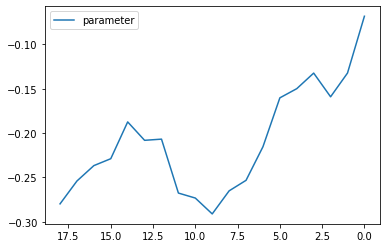

In [249]:
sns.lineplot(data=pd.DataFrame(IV_reg.params.iloc[1:-2]).reset_index())
plt.gca().invert_xaxis()

In [230]:
dic_estimate = {}
dic_confidence = {}
for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    IV_reg = IVGMM(
        data["ln_price"],
        data[["const", "ln_econ_seat_1", "duration"]],
        data["ln_econ_seat"],
        data[["weekday", "depart_hour"]],
    ).fit()

    dic_estimate[i] = IV_reg.params["ln_econ_seat"]
    dic_confidence[i] = IV_reg.conf_int().loc["ln_econ_seat"].values

/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

<ipython-input-231-c50da3f670be>:18: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("index", "x", data=estimates, color="black", linewidth=1.5)


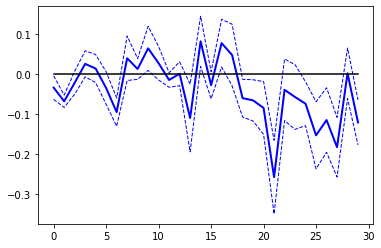

In [231]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:30, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index", "x", data=estimates, color="black", linewidth=1.5)

In [ ]:
 ln_econ_seat.shift(1) + ln_econ_seat.shift(2)

In [33]:
dic_estimate = {}
dic_confidence = {}

for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    model = smf.ols(
        formula="ln_price ~ ln_econ_seat + ln_econ_seat_1 + duration + weekday + depart_hour",
        data=data,
    )
    OLS_reg = model.fit(
        cov_type="cluster",
        cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
    )

    variable = "ln_econ_seat"

    dic_estimate[i] = OLS_reg.params[variable]
    dic_confidence[i] = OLS_reg.conf_int().loc[variable].values

KeyError: 'days_till_dep'

<ipython-input-229-2abcc135c04f>:18: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("index","x", data=estimates, color="black", linewidth=1.5)


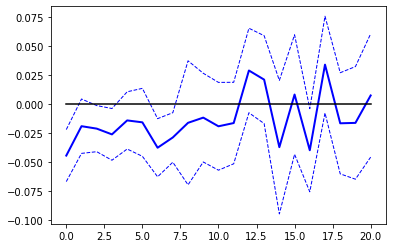

In [229]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:20, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index","x", data=estimates, color="black", linewidth=1.5)